In [1]:
import torch
import matplotlib.pyplot as plt
import librosa
import json
from torch import nn
import numpy as np
import d2l.torch as d2l
from torch.utils.data import DataLoader,TensorDataset
import math
import random


In [2]:
DATA_DIR = './genres'
JSON_PATH = 'data.json'
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.9
TRAIN_OVDER_ALL = 0.7
BATCH_SIZE = 32
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # seconds
SAMPLE_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
def save_json(data_path,json_path,n_mfcc=13,n_fft=2048,hop_len=512,n_segments=5):#using mfcc
    '''
        :n_segments :Number of segments we want to divide a sample track into
    '''
    data = {
        'mapping':[],
        'labels':[],
        'mfcc':[]
    }
    samples_per_segment = SAMPLE_PER_TRACK // n_segments
    n_mfcc_vectors_per_segment = (samples_per_segment+hop_len-1)//hop_len
    

    for i, (dirpath,dirnames,filenames) in enumerate(os.walk(data_path)):
        if dirpath is not data_path:
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print(f"Processing:{label}")

            for f in filenames:
                file_path = os.path.join(dirpath,f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(n_segments):
                    st = samples_per_segment * d
                    en = st + samples_per_segment

                    mfcc = librosa.feature.mfcc(signal[st:en],sample_rate,n_mfcc=n_mfcc,n_fft=n_fft,hop_length=hop_len)
                    mfcc = mfcc.T

                    if len(mfcc) == n_mfcc_vectors_per_segment:
                        data['mfcc'].append(mfcc.tolist()) 
                        data['labels'].append(i-1)
    print(data)
    with open(json_path,'w') as f:
        json.dump(data,f,indent=4)                

save_json(DATA_DIR,JSON_PATH,n_segments=10)

Processing:genres\blues
Processing:genres\classical
Processing:genres\country
Processing:genres\disco
Processing:genres\hiphop
Processing:genres\jazz
Processing:genres\metal
Processing:genres\pop
Processing:genres\reggae
Processing:genres\rock
{'mapping': ['genres\\blues', 'genres\\classical', 'genres\\country', 'genres\\disco', 'genres\\hiphop', 'genres\\jazz', 'genres\\metal', 'genres\\pop', 'genres\\reggae', 'genres\\rock'], 'labels': [], 'mfcc': []}


In [4]:
def load_data(json_path):
    with open(json_path,'r') as f:
        data = json.load(f,encoding='gb18030')
    X, y = np.array(data['mfcc']), np.array(data['labels'])
    return X, y

In [5]:
X, y = load_data(JSON_PATH) 
X = X.astype(np.float32)


In [6]:
X, y = torch.from_numpy(X), torch.from_numpy(y)
data_loader = TensorDataset(X,y)

In [7]:
def split_train_test(data_loader,ratio=0.7):
    cnt = dict()
    for X,y in data_loader:
        if y.item() in cnt.keys():
            cnt[y.item()]+=ratio
        else:
            cnt[y.item()]=ratio
    
    train_dataloader = []
    test_dataloader = []
    index = [i for i in range(len(data_loader))]
    random.shuffle(index)
    for i in range(len(index)):
        X,y = data_loader[index[i]]
        cnt[y.item()]-=1
        if cnt[y.item()]>=0:
            train_dataloader.append((X,y))
        else :
            test_dataloader.append((X,y))
    return train_dataloader, test_dataloader




In [8]:
train_dataloader, test_dataloader = split_train_test(data_loader,TRAIN_OVDER_ALL)
train_dataloader = DataLoader(train_dataloader,batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataloader,batch_size=BATCH_SIZE)

In [9]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, device,
          epochs):
    animator = d2l.Animator(xlabel='epoch',
                            xlim=[1, epochs],
                            ylim=[0, 1],
                            legend=['train acc', 'test acc'])
    n_batches = len(train_dataloader)
    for epoch in range(epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            predict = model(X)
            optimizer.zero_grad()
            loss = loss_fn(predict, y.long()).sum()
            loss.backward()
            with torch.no_grad():
                metric.add(d2l.accuracy(predict, y), X.shape[0])
            optimizer.step()
            train_acc = metric[0] / metric[1]
            if (i + 1) % (n_batches // 5) == 0 or i == n_batches - 1:
                animator.add(epoch + (i + 1) / n_batches, (train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(model, test_dataloader)
        animator.add(epoch + 1, (None, test_acc))
    print(f'train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')


In [10]:
class RNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.gru = nn.GRU(13,65,2,batch_first=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.gru(x)[0] + x.repeat(1,1,5)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x) + x
        x = self.pool(x)
        x = self.conv3(x) + x
        x = self.pool(x)
        x = self.conv4(x) + x.repeat(1,2,1,1)
        x = self.pool(x)
        x = self.conv5(x) + x
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [11]:
model = RNN(10).to(device) 
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4,weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()

train acc 1.000, test acc 0.913


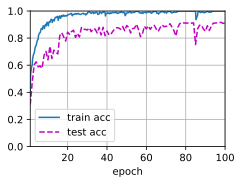

In [12]:
train(model,train_dataloader,test_dataloader,optimizer,loss_fn,device,100)